# Try for obtaining MASC's graph for Magnetar SGR 0526−66

In [1]:
#importamos en primer lugar los modulos que vayamos a usar
from gammaALPs.core import Source, ALP, ModuleList
from gammaALPs.base.transfer import EminGeV, EmaxGeV
import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as c
from gammaALPs.base import environs, transfer
from ebltable.tau_from_model import OptDepth

We first import the relevant modules:

In [2]:
m, g = 3.96, 1.01 #sacado del paper de MASC
alp = ALP(m, g)

Let's define an energy range for this example, in GeV.

In [3]:
EGeV = np.logspace(-1., 2.5, 500) #provisional, modificable

For the initial polarization, we'll use the following one:

In [4]:
pin = np.diag((1., 1., 0.))*0.5 #non polarized

Let's generate the Source using the right parameters, in this case, the central galaxy cluster of perseus

In [5]:
ngc1275 = Source(z = 0.017559, ra = '03h19m48.1s', dec = '+41d30m42s')

With the defined `alp`, `src`, initial polarization `pin` and energy range `EGeV`, we can now initialize our module list

# Cosas que hacer

    1. Ejecutar los modulos por separado para ver como funcionan y como contribuyen a la gráfica final ✅
    
    2. Intentar representar los 4 modulos en un grid de 4 graficas ✅
    
    3. Comprobar la diferencia que existe a meterle 10 simulaciones a ICMCell y 1 a ICMGaussTurb y viceversa
    
    4. Realizar simulaciones progresivamente mas tochas usando r_abell = 500 y L0 = 10 en ICMCell

## 1. Buscamos aislar los módulos y ver como funcionan por separado

In [6]:
# creamos los 4 ml's para los cuales aplicaremos cada uno de los módulos

ml1 = ModuleList(alp, ngc1275, pin=pin, EGeV=EGeV, seed=0)
ml2 = ModuleList(alp, ngc1275, pin=pin, EGeV=EGeV, seed=0)
ml3 = ModuleList(alp, ngc1275, pin=pin, EGeV=EGeV, seed=0)
ml4 = ModuleList(alp, ngc1275, pin=pin, EGeV=EGeV, seed=0)

In [7]:
# aplicamos ICMCell al ml1 y lo ejecutamos

ml1.add_propagation(environ='ICMCell',
                   order=0,   # order of the module
                   B0=25.,  # B field strength
                   L0=10.,  # cell size
                   nsim=1,  # one single realization
                   n0=1e-3,  # electron density
                   r_abell=500.001,  # full path, chosen that we only have a single cell
                   beta=0.,
                   eta=0.
                  )

px1, py1, pa1 = ml1.run()

environs.py: 257 --- INFO: Using inputted chi
environs.py: 270 --- WARNING: r_abell <= L0: assuming one domain from 0. to L0
   core.py: 658 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixICMCell'>


In [8]:
# aplicamos ICMGaussTurb al ml2 y lo ejecutamos

ml2.add_propagation("ICMGaussTurb",
                  0, # position of module counted from the source.
                  nsim=1, # number of random B-field realizations
                  B0=10.,  # rms of B field in muG
                  n0=3.9e-2,  # normalization of electron density in cm-3
                  n2=4.05e-3, # second normalization of electron density, see Churazov et al. 2003, Eq. 4 on cm-3
                  r_abell=500., # extension of the cluster in kpc
                  r_core=80.,   # electron density parameter, see Churazov et al. 2003, Eq. 4 in kpc
                  r_core2=280., # electron density parameter, see Churazov et al. 2003, Eq. 4 in kpc
                  beta=1.2,  # electron density parameter, see Churazov et al. 2003, Eq. 4
                  beta2=0.58, # electron density parameter, see Churazov et al. 2003, Eq. 4
                  eta=0.5, # scaling of B-field with electron denstiy
                  kL=0.18, # maximum turbulence scale in kpc^-1, taken from A2199 cool-core cluster, see Vacca et al. 2012
                  kH=9.,  # minimum turbulence scale, taken from A2199 cool-core cluster, see Vacca et al. 2012
                  q=-2.80, # turbulence spectral index, taken from A2199 cool-core cluster, see Vacca et al. 2012
                  seed=0 # random seed for reproducability, set to None for random seed.
                 )


px2, py2, pa2 = ml2.run()

environs.py: 431 --- INFO: Using inputted chi
   core.py: 658 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixICMGaussTurb'>


In [9]:
# aplicamos modelos intergalacticos al ml3 y lo ejecutamos

ml3.add_propagation("IGMF",
                  0, # position of module counted from the source.
                  nsim=1, # number of random B-field realizations
                  B0=1e-3,  # B field strength in micro Gauss at z = 0
                  n0=1e-7,  # normalization of electron density in cm^-3 at z = 0
                  L0=1e3, # coherence (cell) length in kpc at z = 0
                  eblmodel='dominguez' # EBL model
                  )

ml3.add_propagation("EBL",0, eblmodel = 'dominguez') # EBL attenuation comes second, after beam has left cluster



px3, py3, pa3 = ml3.run()

   core.py: 658 --- INFO: Running Module 1: <class 'gammaALPs.base.environs.MixIGMFCell'>


In [10]:
# aplicamos el GMF al ml4 y lo ejecutamos

ml4.add_propagation("GMF",3, model = 'jansson12', model_sym = 'BSS') # finally, the beam enters the Milky Way Field

px4, py4, pa4 = ml4.run()

environs.py:1196 --- INFO: Using inputted chi
   core.py: 658 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixGMF'>


# 2. Ploteamos las 4 gráficas en un grid

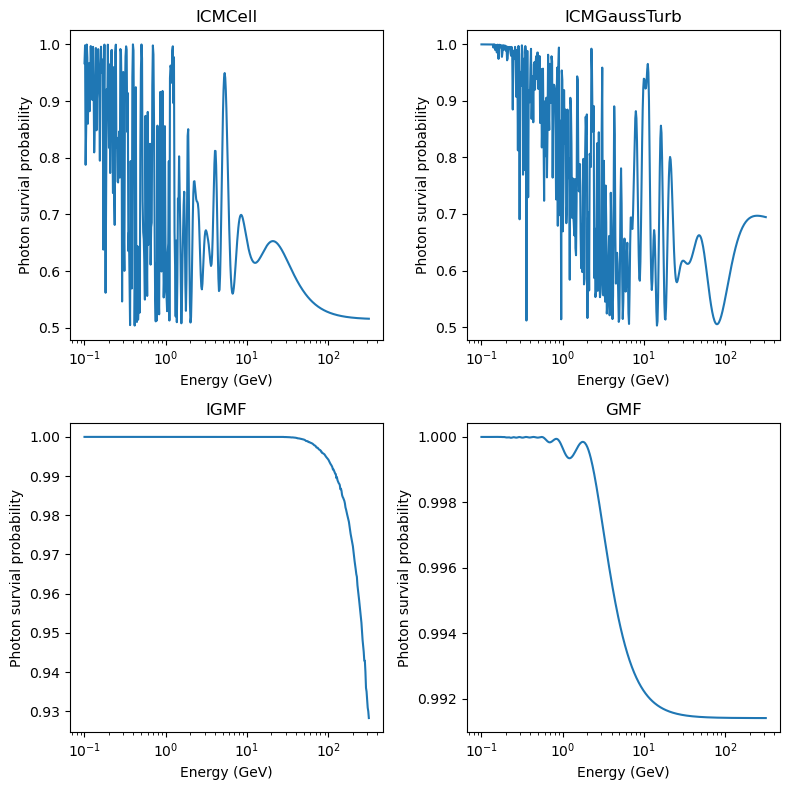

In [11]:
# Crear un cuadrado de 2x2 subgráficas
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

# Plot 1
axs[0, 0].semilogx(EGeV, px1[0] + py1[0])
axs[0, 0].set_title('ICMCell')
axs[0, 0].set_xlabel('Energy (GeV)')
axs[0, 0].set_ylabel('Photon survial probability')

# Plot 2
axs[0, 1].semilogx(EGeV, px2[0] + py2[0])
axs[0, 1].set_title('ICMGaussTurb')
axs[0, 1].set_xlabel('Energy (GeV)')
axs[0, 1].set_ylabel('Photon survial probability')

# Plot 3
axs[1, 0].semilogx(EGeV, px3[0] + py3[0])
axs[1, 0].set_title('IGMF')
axs[1, 0].set_xlabel('Energy (GeV)')
axs[1, 0].set_ylabel('Photon survial probability')

# Plot 4
axs[1, 1].semilogx(EGeV, px4[0] + py4[0])
axs[1, 1].set_title('GMF')
axs[1, 1].set_xlabel('Energy (GeV)')
axs[1, 1].set_ylabel('Photon survial probability')

# Ajustar diseño
plt.tight_layout()

# Mostrar la gráfica
plt.show()

## 3. Comprobemos la diferencia que existe al usar 10 simulaciones a ICMCell y 1 a ICMGaussTurb y viceversa

### 3.a) Primero cada uno por separado (primero ICMCell y despues ICMGaussTurb)

environs.py: 257 --- INFO: Using inputted chi
environs.py: 270 --- WARNING: r_abell <= L0: assuming one domain from 0. to L0
environs.py: 257 --- INFO: Using inputted chi
environs.py: 270 --- WARNING: r_abell <= L0: assuming one domain from 0. to L0
   core.py: 658 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixICMCell'>
   core.py: 658 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixICMCell'>


Text(0, 0.5, 'Photon survial probability')

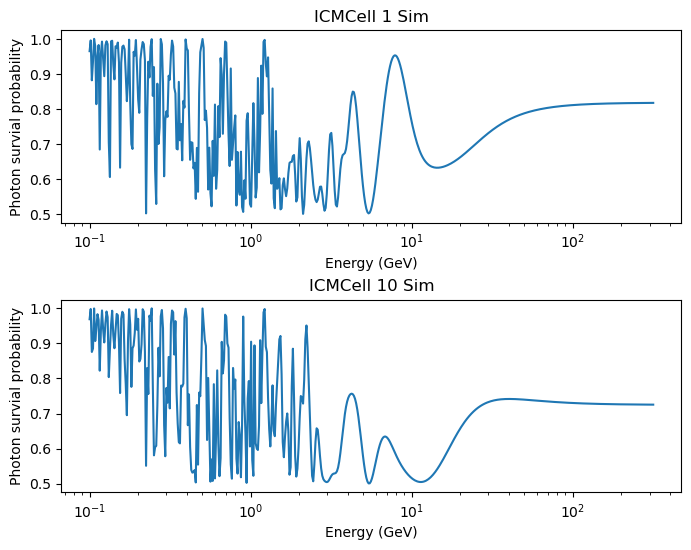

In [12]:
# creamos los ml que vayamos a usar en este caso e introducimos sus modulos de propagación

ml_ICMCell_1 = ModuleList(alp, ngc1275, pin=pin, EGeV=EGeV, seed=0)
ml_ICMCell_10 = ModuleList(alp, ngc1275, pin=pin, EGeV=EGeV, seed=0)

ml_ICMCell_1.add_propagation(environ='ICMCell',
                   order=0,   # order of the module
                   B0=25.,  # B field strength
                   L0=10.,  # cell size
                   nsim=1,  # one single realization
                   n0=1e-3,  # electron density
                   r_abell=500.001,  # full path, chosen that we only have a single cell
                   beta=0.,
                   eta=0.
                  )

ml_ICMCell_10.add_propagation(environ='ICMCell',
                   order=0,   # order of the module
                   B0=25.,  # B field strength
                   L0=10.,  # cell size
                   nsim=10,  # one single realization
                   n0=1e-3,  # electron density
                   r_abell=500.001,  # full path, chosen that we only have a single cell
                   beta=0.,
                   eta=0.
                  )

px_ICMCell_1, py_ICMCell_1, pa1_ICMCell_1 = ml_ICMCell_1.run()

px_ICMCell_10, py_ICMCell_10, pa1_ICMCell_10 = ml_ICMCell_10.run()

# Crear un cuadrado de 2x1 subgráficas
fig, axs = plt.subplots(2, 1, figsize=(8, 6), gridspec_kw={'hspace': 0.4})

# Plot 1
axs[0].semilogx(EGeV, px_ICMCell_1[0] + py_ICMCell_1[0])
axs[0].set_title('ICMCell 1 Sim')
axs[0].set_xlabel('Energy (GeV)')
axs[0].set_ylabel('Photon survial probability')


# Plot 2
axs[1].semilogx(EGeV, px_ICMCell_10[0] + py_ICMCell_10[0])
axs[1].set_title('ICMCell 10 Sim')
axs[1].set_xlabel('Energy (GeV)')
axs[1].set_ylabel('Photon survial probability')

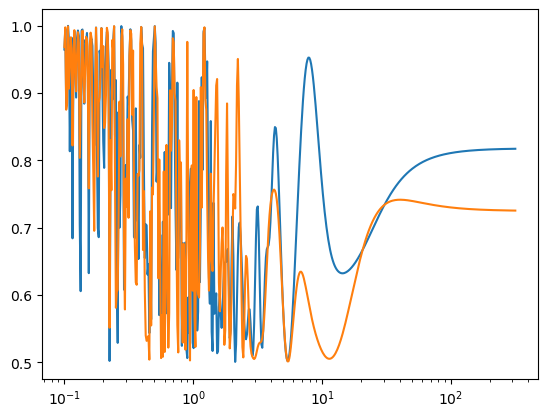

In [13]:
plt.semilogx(EGeV, px_ICMCell_1[0] + py_ICMCell_1[0])
plt.semilogx(EGeV, px_ICMCell_10[0] + py_ICMCell_10[0])

Con 10 simulaciones no se aprecia ninguna diferencia, voy a probar con 100

environs.py: 257 --- INFO: Using inputted chi
environs.py: 270 --- WARNING: r_abell <= L0: assuming one domain from 0. to L0
environs.py: 257 --- INFO: Using inputted chi
environs.py: 270 --- WARNING: r_abell <= L0: assuming one domain from 0. to L0
   core.py: 658 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixICMCell'>
   core.py: 658 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixICMCell'>


Text(0, 0.5, 'Photon survial probability')

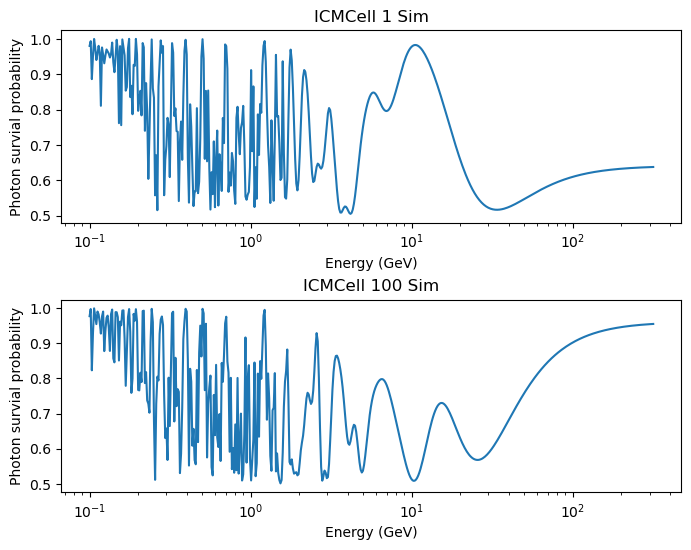

In [14]:
ml_ICMCell_1 = ModuleList(alp, ngc1275, pin=pin, EGeV=EGeV, seed=0)
ml_ICMCell_100 = ModuleList(alp, ngc1275, pin=pin, EGeV=EGeV, seed=0)

ml_ICMCell_1.add_propagation(environ='ICMCell',
                   order=0,   # order of the module
                   B0=25.,  # B field strength
                   L0=10.,  # cell size
                   nsim=1,  # one single realization
                   n0=1e-3,  # electron density
                   r_abell=500.001,  # full path, chosen that we only have a single cell
                   beta=0.,
                   eta=0.
                  )

ml_ICMCell_100.add_propagation(environ='ICMCell',
                   order=0,   # order of the module
                   B0=25.,  # B field strength
                   L0=10.,  # cell size
                   nsim=10,  # one single realization
                   n0=1e-3,  # electron density
                   r_abell=500.001,  # full path, chosen that we only have a single cell
                   beta=0.,
                   eta=0.
                  )

px_ICMCell_1, py_ICMCell_1, pa1_ICMCell_1 = ml_ICMCell_1.run()

px_ICMCell_100, py_ICMCell_100, pa1_ICMCell_100 = ml_ICMCell_100.run()

# Crear un cuadrado de 2x1 subgráficas
fig, axs = plt.subplots(2, 1, figsize=(8, 6), gridspec_kw={'hspace': 0.4})

# Plot 1
axs[0].semilogx(EGeV, px_ICMCell_1[0] + py_ICMCell_1[0])
axs[0].set_title('ICMCell 1 Sim')
axs[0].set_xlabel('Energy (GeV)')
axs[0].set_ylabel('Photon survial probability')


# Plot 2
axs[1].semilogx(EGeV, px_ICMCell_100[0] + py_ICMCell_100[0])
axs[1].set_title('ICMCell 100 Sim')
axs[1].set_xlabel('Energy (GeV)')
axs[1].set_ylabel('Photon survial probability')

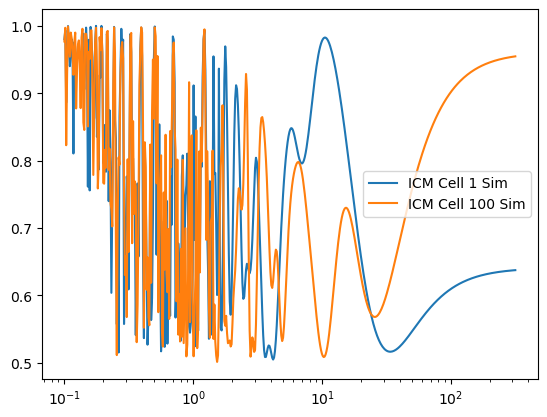

In [15]:
# Crear un cuadrado de 2x1 subgráficas
figsize = (8, 6)
plt.semilogx(EGeV, px_ICMCell_1[0] + py_ICMCell_1[0], label = "ICM Cell 1 Sim")
plt.semilogx(EGeV, px_ICMCell_100[0] + py_ICMCell_100[0], label = "ICM Cell 100 Sim")
plt.legend()
plt.show()

Ahora hagamos lo mismo con ICMGaussTurb

environs.py: 431 --- INFO: Using inputted chi
environs.py: 431 --- INFO: Using inputted chi
   core.py: 658 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixICMGaussTurb'>
   core.py: 658 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixICMGaussTurb'>


Text(0, 0.5, 'Photon survial probability')

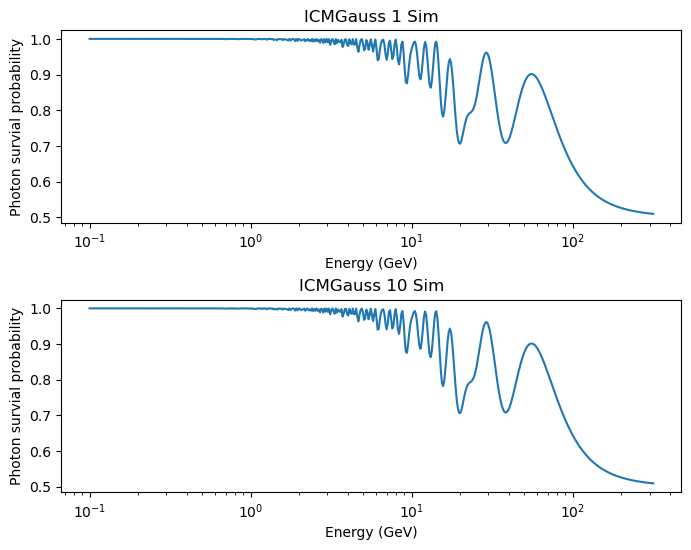

In [16]:
# creamos los ml que vayamos a usar en este caso e introducimos sus modulos de propagación

ml_ICMGauss_1 = ModuleList(alp, ngc1275, pin=pin, EGeV=EGeV, seed=0)
ml_ICMGauss_10 = ModuleList(alp, ngc1275, pin=pin, EGeV=EGeV, seed=0)

ml_ICMGauss_1.add_propagation(environ='ICMGaussTurb',
                   order=0,   # order of the module
                   B0=25.,  # B field strength
                   L0=10.,  # cell size
                   nsim=1,  # one single realization
                   n0=1e-3,  # electron density
                   r_abell=500.001,  # full path, chosen that we only have a single cell
                   beta=0.,
                   eta=0.
                  )

ml_ICMGauss_10.add_propagation(environ='ICMGaussTurb',
                   order=0,   # order of the module
                   B0=25.,  # B field strength
                   L0=10.,  # cell size
                   nsim=10,  # one single realization
                   n0=1e-3,  # electron density
                   r_abell=500.001,  # full path, chosen that we only have a single cell
                   beta=0.,
                   eta=0.
                  )

px_ICMGauss_1, py_ICMGauss_1, pa1_ICMGauss_1 = ml_ICMGauss_1.run()

px_ICMGauss_10, py_ICMGauss_10, pa1_ICMGauss_10 = ml_ICMGauss_10.run()

# Crear un cuadrado de 2x1 subgráficas
fig, axs = plt.subplots(2, 1, figsize=(8, 6), gridspec_kw={'hspace': 0.4})

# Plot 1
axs[0].semilogx(EGeV, px_ICMGauss_1[0] + py_ICMGauss_1[0])
axs[0].set_title('ICMGauss 1 Sim')
axs[0].set_xlabel('Energy (GeV)')
axs[0].set_ylabel('Photon survial probability')


# Plot 2
axs[1].semilogx(EGeV, px_ICMGauss_10[0] + py_ICMGauss_10[0])
axs[1].set_title('ICMGauss 10 Sim')
axs[1].set_xlabel('Energy (GeV)')
axs[1].set_ylabel('Photon survial probability')

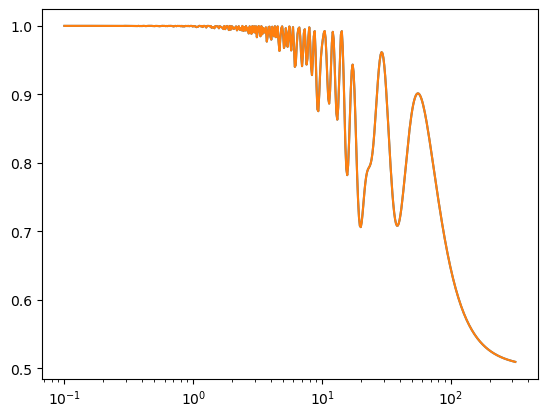

In [17]:
plt.semilogx(EGeV, px_ICMGauss_1[0] + py_ICMGauss_1[0])
plt.semilogx(EGeV, px_ICMGauss_10[0] + py_ICMGauss_10[0])

Literalmente no se mueve

### 3.b) Ahora ambos modulos juntos

In [18]:
# creamos el ml y primero ejecutamos con 1 sim en ICMCell y despues con 10 sims

ml_mix1 = ModuleList(alp, ngc1275, pin=pin, EGeV=EGeV, seed=0)

ml_mix1.add_propagation(environ='ICMCell',
                   order=0,   # order of the module
                   B0=25.,  # B field strength
                   L0=10.,  # cell size
                   nsim=1,  # one single realization
                   n0=1e-3,  # electron density
                   r_abell=500.001,  # full path, chosen that we only have a single cell
                   beta=0.,
                   eta=0.
                  )

ml_mix1.add_propagation("ICMGaussTurb",
                  1, # position of module counted from the source.
                  nsim=100, # number of random B-field realizations
                  B0=10.,  # rms of B field in muG
                  n0=3.9e-2,  # normalization of electron density in cm-3
                  n2=4.05e-3, # second normalization of electron density, see Churazov et al. 2003, Eq. 4 on cm-3
                  r_abell=500., # extension of the cluster in kpc
                  r_core=80.,   # electron density parameter, see Churazov et al. 2003, Eq. 4 in kpc
                  r_core2=280., # electron density parameter, see Churazov et al. 2003, Eq. 4 in kpc
                  beta=1.2,  # electron density parameter, see Churazov et al. 2003, Eq. 4
                  beta2=0.58, # electron density parameter, see Churazov et al. 2003, Eq. 4
                  eta=0.5, # scaling of B-field with electron denstiy
                  kL=0.18, # maximum turbulence scale in kpc^-1, taken from A2199 cool-core cluster, see Vacca et al. 2012
                  kH=9.,  # minimum turbulence scale, taken from A2199 cool-core cluster, see Vacca et al. 2012
                  q=-2.80, # turbulence spectral index, taken from A2199 cool-core cluster, see Vacca et al. 2012
                  seed=0 # random seed for reproducability, set to None for random seed.
                 )

ml_mix2 = ModuleList(alp, ngc1275, pin=pin, EGeV=EGeV, seed=0)

ml_mix2.add_propagation(environ='ICMCell',
                   order=0,   # order of the module
                   B0=25.,  # B field strength
                   L0=10.,  # cell size
                   nsim=100,  # one single realization
                   n0=1e-3,  # electron density
                   r_abell=500.001,  # full path, chosen that we only have a single cell
                   beta=0.,
                   eta=0.
                  )

ml_mix2.add_propagation("ICMGaussTurb",
                  1, # position of module counted from the source.
                  nsim=1, # number of random B-field realizations
                  B0=10.,  # rms of B field in muG
                  n0=3.9e-2,  # normalization of electron density in cm-3
                  n2=4.05e-3, # second normalization of electron density, see Churazov et al. 2003, Eq. 4 on cm-3
                  r_abell=500., # extension of the cluster in kpc
                  r_core=80.,   # electron density parameter, see Churazov et al. 2003, Eq. 4 in kpc
                  r_core2=280., # electron density parameter, see Churazov et al. 2003, Eq. 4 in kpc
                  beta=1.2,  # electron density parameter, see Churazov et al. 2003, Eq. 4
                  beta2=0.58, # electron density parameter, see Churazov et al. 2003, Eq. 4
                  eta=0.5, # scaling of B-field with electron denstiy
                  kL=0.18, # maximum turbulence scale in kpc^-1, taken from A2199 cool-core cluster, see Vacca et al. 2012
                  kH=9.,  # minimum turbulence scale, taken from A2199 cool-core cluster, see Vacca et al. 2012
                  q=-2.80, # turbulence spectral index, taken from A2199 cool-core cluster, see Vacca et al. 2012
                  seed=0 # random seed for reproducability, set to None for random seed.
                 )


px_mix1, py_mix1, pa_mix1 = ml_mix1.run()

px_mix2, py_mix2, pa_mix2 = ml_mix2.run()

environs.py: 257 --- INFO: Using inputted chi
environs.py: 270 --- WARNING: r_abell <= L0: assuming one domain from 0. to L0
environs.py: 431 --- INFO: Using inputted chi
environs.py: 257 --- INFO: Using inputted chi
environs.py: 270 --- WARNING: r_abell <= L0: assuming one domain from 0. to L0
environs.py: 431 --- INFO: Using inputted chi
   core.py: 658 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixICMCell'>
   core.py: 658 --- INFO: Running Module 1: <class 'gammaALPs.base.environs.MixICMGaussTurb'>
   core.py: 658 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixICMCell'>
   core.py: 658 --- INFO: Running Module 1: <class 'gammaALPs.base.environs.MixICMGaussTurb'>


Text(0, 0.5, 'Photon survial probability')

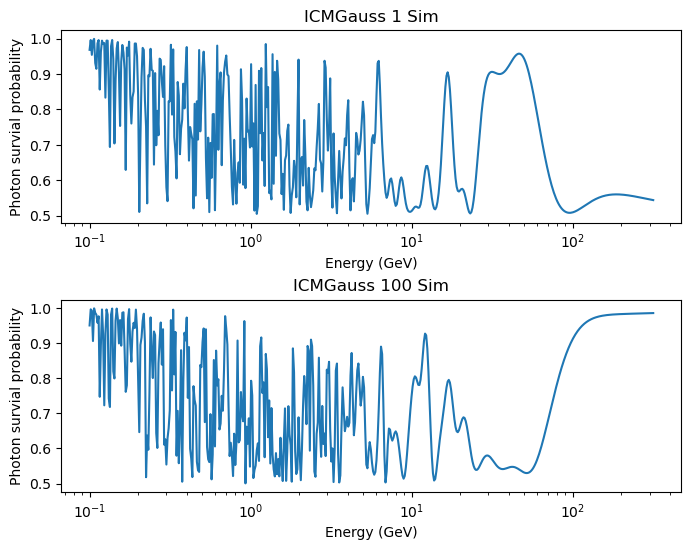

In [19]:
# Crear un cuadrado de 2x1 subgráficas
fig, axs = plt.subplots(2, 1, figsize=(8, 6), gridspec_kw={'hspace': 0.4})

# Plot 1
axs[0].semilogx(EGeV, px_mix1[0] + py_mix1[0])
axs[0].set_title('ICMGauss 1 Sim')
axs[0].set_xlabel('Energy (GeV)')
axs[0].set_ylabel('Photon survial probability')


# Plot 2
axs[1].semilogx(EGeV, px_mix2[0] + py_mix2[0])
axs[1].set_title('ICMGauss 100 Sim')
axs[1].set_xlabel('Energy (GeV)')
axs[1].set_ylabel('Photon survial probability')

Se aprecia diferencia, esta claro que las turbulencias son mayores en el segundo caso donde aplicamos 10 simulaciones al campo magnético total, en el otro caso las simulaciones se van al rms del campo magnético.

Do this for 1000 simulations and plot the median and sigma deviation

## Queremos hacer 1000 simulaciones vs 1simulacion y plotear también las sigmas

In [20]:
# creamos el ml y primero ejecutamos con 1 sim en ICMCell y despues con 10 sims

ml_mix1 = ModuleList(alp, ngc1275, pin=pin, EGeV=EGeV, seed=0)

ml_mix1.add_propagation(environ='ICMCell',
                   order=0,   # order of the module
                   B0=25.,  # B field strength
                   L0=10.,  # cell size
                   nsim=1,  # one single realization
                   n0=1e-3,  # electron density
                   r_abell=500.001,  # full path, chosen that we only have a single cell
                   beta=0.,
                   eta=0.
                  )

ml_mix1.add_propagation("ICMGaussTurb",
                  1, # position of module counted from the source.
                  nsim=1000, # number of random B-field realizations
                  B0=10.,  # rms of B field in muG
                  n0=3.9e-2,  # normalization of electron density in cm-3
                  n2=4.05e-3, # second normalization of electron density, see Churazov et al. 2003, Eq. 4 on cm-3
                  r_abell=500., # extension of the cluster in kpc
                  r_core=80.,   # electron density parameter, see Churazov et al. 2003, Eq. 4 in kpc
                  r_core2=280., # electron density parameter, see Churazov et al. 2003, Eq. 4 in kpc
                  beta=1.2,  # electron density parameter, see Churazov et al. 2003, Eq. 4
                  beta2=0.58, # electron density parameter, see Churazov et al. 2003, Eq. 4
                  eta=0.5, # scaling of B-field with electron denstiy
                  kL=0.18, # maximum turbulence scale in kpc^-1, taken from A2199 cool-core cluster, see Vacca et al. 2012
                  kH=9.,  # minimum turbulence scale, taken from A2199 cool-core cluster, see Vacca et al. 2012
                  q=-2.80, # turbulence spectral index, taken from A2199 cool-core cluster, see Vacca et al. 2012
                  seed=0 # random seed for reproducability, set to None for random seed.
                 )

ml_mix2 = ModuleList(alp, ngc1275, pin=pin, EGeV=EGeV, seed=0)

ml_mix2.add_propagation(environ='ICMCell',
                   order=0,   # order of the module
                   B0=25.,  # B field strength
                   L0=10.,  # cell size
                   nsim=1000,  # one single realization
                   n0=1e-3,  # electron density
                   r_abell=500.001,  # full path, chosen that we only have a single cell
                   beta=0.,
                   eta=0.
                  )

ml_mix2.add_propagation("ICMGaussTurb",
                  1, # position of module counted from the source.
                  nsim=1, # number of random B-field realizations
                  B0=10.,  # rms of B field in muG
                  n0=3.9e-2,  # normalization of electron density in cm-3
                  n2=4.05e-3, # second normalization of electron density, see Churazov et al. 2003, Eq. 4 on cm-3
                  r_abell=500., # extension of the cluster in kpc
                  r_core=80.,   # electron density parameter, see Churazov et al. 2003, Eq. 4 in kpc
                  r_core2=280., # electron density parameter, see Churazov et al. 2003, Eq. 4 in kpc
                  beta=1.2,  # electron density parameter, see Churazov et al. 2003, Eq. 4
                  beta2=0.58, # electron density parameter, see Churazov et al. 2003, Eq. 4
                  eta=0.5, # scaling of B-field with electron denstiy
                  kL=0.18, # maximum turbulence scale in kpc^-1, taken from A2199 cool-core cluster, see Vacca et al. 2012
                  kH=9.,  # minimum turbulence scale, taken from A2199 cool-core cluster, see Vacca et al. 2012
                  q=-2.80, # turbulence spectral index, taken from A2199 cool-core cluster, see Vacca et al. 2012
                  seed=0 # random seed for reproducability, set to None for random seed.
                 )


px_mix1, py_mix1, pa_mix1 = ml_mix1.run()

px_mix2, py_mix2, pa_mix2 = ml_mix2.run()

environs.py: 257 --- INFO: Using inputted chi
environs.py: 270 --- WARNING: r_abell <= L0: assuming one domain from 0. to L0
environs.py: 431 --- INFO: Using inputted chi
environs.py: 257 --- INFO: Using inputted chi
environs.py: 270 --- WARNING: r_abell <= L0: assuming one domain from 0. to L0
environs.py: 431 --- INFO: Using inputted chi
   core.py: 658 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixICMCell'>
   core.py: 658 --- INFO: Running Module 1: <class 'gammaALPs.base.environs.MixICMGaussTurb'>
   core.py: 658 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixICMCell'>
   core.py: 658 --- INFO: Running Module 1: <class 'gammaALPs.base.environs.MixICMGaussTurb'>


In [21]:
#calculamos mediana y STD

mediana1 = np.median(pa_mix1, axis=0)
sigma1 = np.std(1 - pa_mix1, axis=0)

mediana2 = np.median(pa_mix2, axis=0)
sigma2 = np.std(1 - pa_mix2, axis=0)

Text(0.5, 1.0, '1000 sims for ICMGaussTurb')

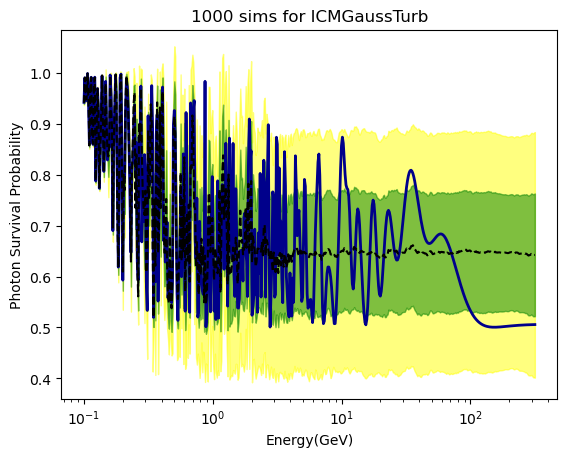

In [27]:
#ploteamos para la primera simulacion
plt.semilogx(EGeV, px_mix1[0] + py_mix1[0],
             label='One Realization',
             color='darkblue',
             lw = 2
            )


plt.plot(EGeV, (1-mediana1),
        label='Median',
        linestyle='--',
        color='k')



plt.fill_between(EGeV, 1 - mediana1 - 2*sigma1, 1 - mediana1 + 2*sigma1, color='yellow', alpha=0.5, label='±1 sigma')

plt.fill_between(EGeV, 1 - mediana1 - sigma1, 1 - mediana1 + sigma1, color='green', alpha=0.5, label='±2 sigma')

plt.xlabel("Energy(GeV)")
plt.ylabel("Photon Survival Probability")
plt.title("1000 sims for ICMGaussTurb")
plt.legend()
plt.show()

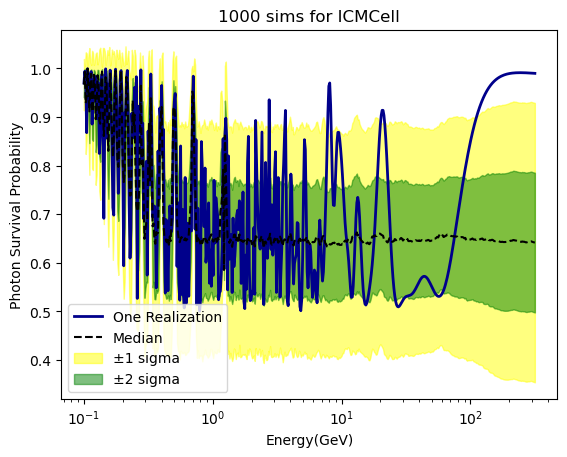

In [30]:
#ploteamos para la primera simulacion
plt.semilogx(EGeV, px_mix2[0] + py_mix2[0],
             label='One Realization',
             color='darkblue',
             lw = 2
            )


plt.plot(EGeV, (1-mediana2),
        label='Median',
        linestyle='--',
        color='k')



plt.fill_between(EGeV, 1 - mediana2 - 2*sigma2, 1 - mediana2 + 2*sigma2, color='yellow', alpha=0.5, label='±1 sigma')

plt.fill_between(EGeV, 1 - mediana2 - sigma2, 1 - mediana2 + sigma2, color='green', alpha=0.5, label='±2 sigma')


plt.xlabel("Energy(GeV)")
plt.ylabel("Photon Survival Probability")
plt.title("1000 sims for ICMCell")
plt.legend()
plt.show()